<a href="https://colab.research.google.com/github/ratulpathan/DMML-Project/blob/main/social_media_text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
pip install transformers==4.11.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data-1.csv')
df.head()

,reviews.text,reviews.rating,sentiment_score,sentiment,text
0,This product so far has not disappointed. My c...,5.0,1,POSITIVE,product so far have not disappoint my child lo...
1,great for beginner or experienced person. Boug...,5.0,1,POSITIVE,great for beginner or experienced person buy a...
2,Inexpensive tablet for him to use and learn on...,5.0,1,POSITIVE,inexpensive tablet for him use learn on step u...
3,I've had my Fire HD 8 two weeks now and I love...,4.0,1,POSITIVE,i ve have my fire hd two week now i love table...
4,I bought this for my grand daughter when she c...,5.0,1,POSITIVE,i buy for my grand daughter when she come over...


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37727 entries, 0 to 37726
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     37727 non-null  object 
 1   reviews.rating   37727 non-null  float64
 2   sentiment_score  37727 non-null  int64  
 3   sentiment        37727 non-null  object 
 4   text             37726 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.4+ MB


In [20]:
data = df[["reviews.text","reviews.rating"]]
data.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


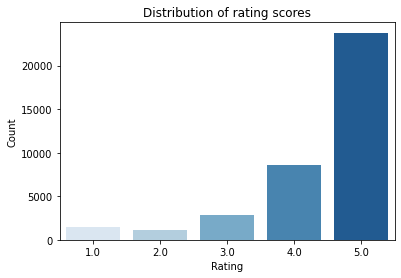

In [21]:
sns.countplot(data['reviews.rating'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [22]:
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['reviews.rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)

data.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
0,This product so far has not disappointed. My c...,5.0,1,POSITIVE
1,great for beginner or experienced person. Boug...,5.0,1,POSITIVE
2,Inexpensive tablet for him to use and learn on...,5.0,1,POSITIVE
3,I've had my Fire HD 8 two weeks now and I love...,4.0,1,POSITIVE
4,I bought this for my grand daughter when she c...,5.0,1,POSITIVE


In [23]:
all_words = pd.Series(' '.join(data['reviews.text']).split())

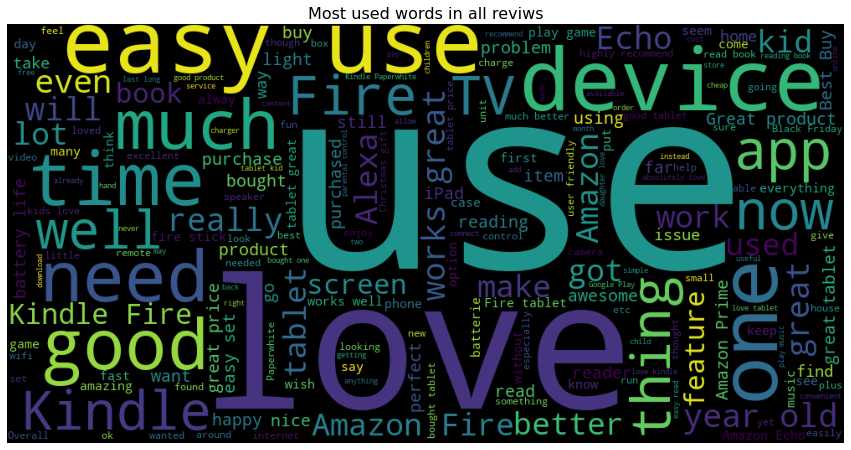

In [24]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_words))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in all reviws", size=16)

plt.axis("off")
plt.show()

In [25]:
positiveWords = pd.Series(' '.join(data[data['sentiment']=='POSITIVE']['reviews.text']).split())

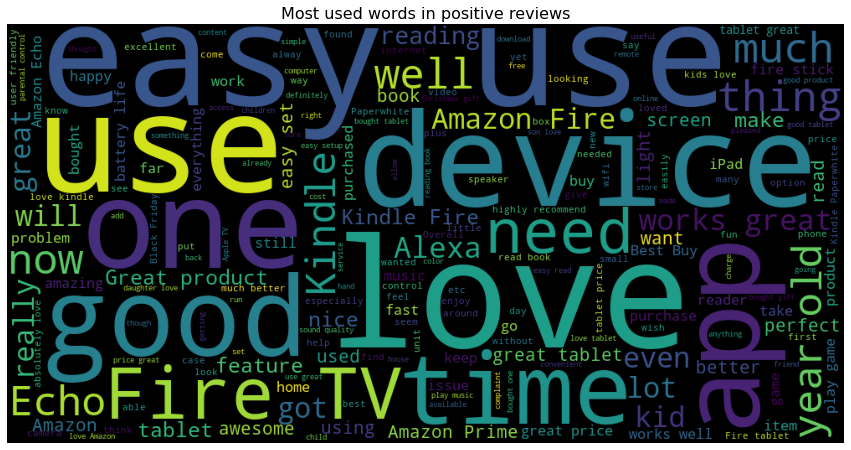

In [26]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positiveWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positive reviews", size=16)

plt.axis("off")
plt.show()

In [27]:
negativeWords = pd.Series(' '.join(data[data['sentiment']=='NEGATIVE']['reviews.text']).split())

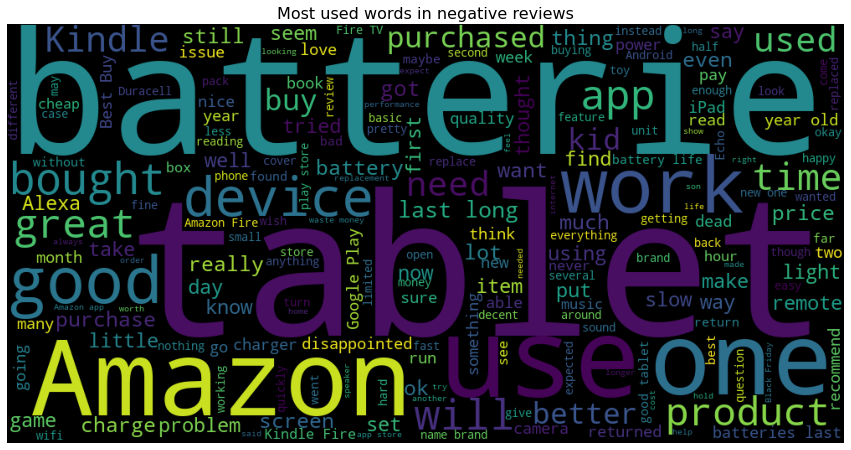

In [28]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize=(15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size=16)

plt.axis("off")
plt.show()

In [29]:
def clean_text(text:str):
    text = str(text)
    
    text = text.lower()
    text = text.strip()
    
    text = re.sub(' \d+', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

In [30]:
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
clean_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'this is a message to be cleaned it may involve some things like adjacent spaces and tabs'

In [31]:
def remove_stopwords(text:str):
    text = str(text)
    filtered_sentence = []

    stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    return text

In [32]:
def stemm_text(text:str):
    text = str(text)
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    stemmed_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    text = " ".join(stemmed_sentence)
    
    return text

In [33]:
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
stemm_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'messag be clean may involv some thing like adjac space tab'

In [34]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [35]:
# clean text
data['text'] = data['reviews.text'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)

In [36]:
data.to_csv('cleaned_data.csv', index=False)

In [37]:
data = pd.read_csv('cleaned_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37727 entries, 0 to 37726
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     37727 non-null  object 
 1   reviews.rating   37727 non-null  float64
 2   sentiment_score  37727 non-null  int64  
 3   sentiment        37727 non-null  object 
 4   text             37726 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.4+ MB


In [38]:
data[data['text'].isnull()]

,reviews.text,reviews.rating,sentiment_score,sentiment,text
9681,.................................................,5.0,1,POSITIVE,NaN


In [39]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37726 entries, 0 to 37726
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews.text     37726 non-null  object 
 1   reviews.rating   37726 non-null  float64
 2   sentiment_score  37726 non-null  int64  
 3   sentiment        37726 non-null  object 
 4   text             37726 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ MB


In [40]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer.fit(data['text'])
features = vectorizer.transform(data['text'])

features.toarray()

array([[0.        , 0.31507952, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [41]:
tf_idf = pd.DataFrame(features.toarray(), columns=vectorizer.get_feature_names())
# tf_idf.drop('50', axis=1, inplace=True)
tf_idf.head()

,50,ability,able,about,absolutely,access,account,actually,add,added,...,wouldn,wrong,year,years,yet,you,young,your,youtube,yr
0,0.0,0.31508,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.00000,0.117019,0.0,0.0,0.133404,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.077066,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.068962,0.0,0.0,0.0,0.0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, data['sentiment_score'], test_size=0.2, random_state=42)

print (f'Train set shape\t:{X_train.shape}\nTest set shape\t:{X_test.shape}')

Train set shape	:(30180, 700)
Test set shape	:(7546, 700)


In [43]:
yy = pd.DataFrame(y_train)
train_data = pd.concat([X_train, yy],axis=1)
train_data.head()

,50,ability,able,about,absolutely,access,account,actually,add,added,...,wrong,year,years,yet,you,young,your,youtube,yr,sentiment_score
0,0.0,0.31508,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
1,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
2,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
3,0.0,0.00000,0.117019,0.0,0.0,0.133404,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.077066,0.0,0.0,0.0,0.0,1.0
5,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.219006,0.0,0.000000,0.0,0.0,0.0,0.0,1.0


In [44]:
train_data['sentiment_score'].value_counts()

1.0    25902
0.0     4278
Name: sentiment_score, dtype: int64

In [45]:
target_count = train_data['sentiment_score'].value_counts()
negative_class = train_data[train_data['sentiment_score'] == 0]
positive_class = train_data[train_data['sentiment_score'] == 1]

negative_over = negative_class.sample(target_count[1], replace=True)

df_train_over = pd.concat([positive_class, negative_over], axis=0)
df_train_over = shuffle(df_train_over)
df_train_over.head()

,50,ability,able,about,absolutely,access,account,actually,add,added,...,wrong,year,years,yet,you,young,your,youtube,yr,sentiment_score
23300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.181023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_train_over.dropna(inplace=True)

In [47]:
df_train_over['sentiment_score'].value_counts()

1.0    22189
0.0    21391
Name: sentiment_score, dtype: int64

In [48]:
X_train = df_train_over.iloc[:,:-1]
y_train = df_train_over['sentiment_score'] 

In [49]:
def modeling(Model, Xtrain = X_train, Xtest = X_test):
    model = Model
    model.fit(Xtrain, y_train)
    
    global y_pred
    y_pred = model.predict(Xtest)
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))
    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":12}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix') 

              precision    recall  f1-score   support

           0       0.46      0.78      0.58      1134
           1       0.96      0.84      0.89      6412

    accuracy                           0.83      7546
   macro avg       0.71      0.81      0.73      7546
weighted avg       0.88      0.83      0.85      7546

AUC  0.8076349899494004


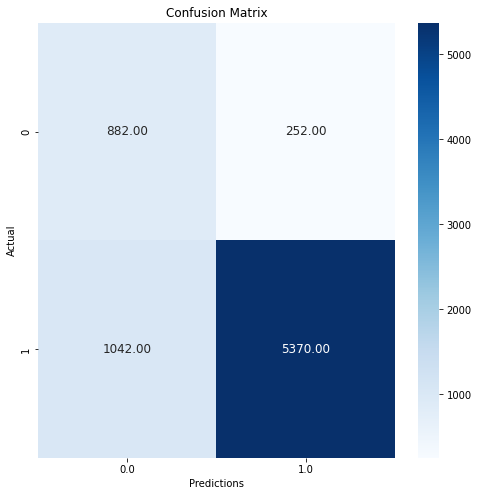

In [50]:
modeling(MultinomialNB())

              precision    recall  f1-score   support

           0       0.55      0.71      0.62      1134
           1       0.95      0.90      0.92      6412

    accuracy                           0.87      7546
   macro avg       0.75      0.80      0.77      7546
weighted avg       0.89      0.87      0.87      7546

AUC  0.8008777908705128


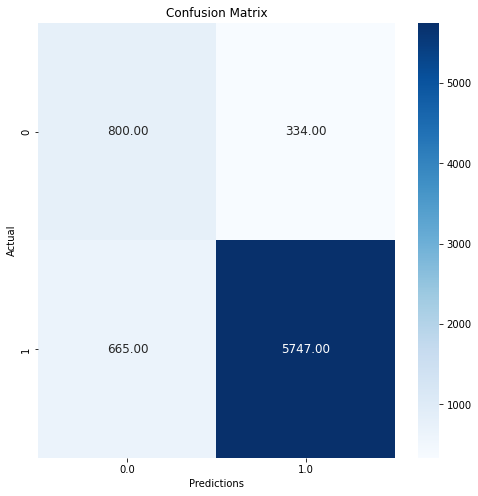

In [51]:
modeling(XGBClassifier());